In [198]:
import torch
import torchvision
import torch.utils
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.models import vgg19, VGG19_Weights
from torchvision.transforms import transforms
import torchvision.datasets as datasets
from torch.utils.data import Subset,DataLoader
from torch.utils.data import Dataset

In [147]:
vgg = vgg19(weights=VGG19_Weights.IMAGENET1K_V1)

In [148]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [149]:
x=torch.rand(3,10)

In [150]:
poo=nn.Linear(10,10)

In [151]:
layer=[]

In [152]:
layer+=[nn.Linear(10,10),nn.ReLU()]

In [153]:
ha=nn.Sequential(*layer)

In [154]:

ya=ha(x)

In [155]:
ya

tensor([[0.0000, 0.0000, 0.0000, 0.2139, 0.2614, 0.2116, 0.4269, 0.0000, 0.0599,
         0.2307],
        [0.0000, 0.0000, 0.0171, 0.0000, 0.5549, 0.2969, 0.7255, 0.0000, 0.2408,
         0.3286],
        [0.0000, 0.1935, 0.0000, 0.0000, 0.3085, 0.2473, 0.3359, 0.0000, 0.3628,
         0.3612]], grad_fn=<ReluBackward0>)

In [156]:
class Resblocks(nn.Module):
    def __init__(self,channel=64):
        super().__init__()
        self.cv1=nn.Conv2d(in_channels=channel,out_channels=channel,kernel_size=3,padding=1,stride=1)
        self.cv2=nn.Conv2d(in_channels=channel,out_channels=channel,kernel_size=3,padding=1,stride=1)
        self.prelu=nn.PReLU()
        self.bn1=nn.BatchNorm2d(channel)
        self.bn2=nn.BatchNorm2d(channel)
    def forward(self,x):
        out=self.cv1(x)
        out=self.bn1(out)
        out=self.prelu(out)
        out=self.cv2(out)
        out=self.bn2(out)
        out=self.prelu(out)
        return x+out
        
        

In [157]:
class SRGenerator(nn.Module):
    def __init__(self,channel=64):
        super().__init__()
        self.firstcv=nn.Conv2d(in_channels=3,out_channels=channel,kernel_size=5,padding=2,stride=1)
        self.midcv=nn.Sequential(*(Resblocks(channel) for _ in range(16)))
        self.prelu=nn.PReLU()
        self.bnmid=nn.BatchNorm2d(channel)
        self.up1=nn.Conv2d(in_channels=channel,out_channels=channel*4,kernel_size=3,padding=1,stride=1)
        self.pixshuf=nn.PixelShuffle(upscale_factor=2)
        self.up2=nn.Conv2d(in_channels=channel,out_channels=channel*4,kernel_size=3,padding=1,stride=1)
        self.finalconv=nn.Conv2d(in_channels=channel,out_channels=3,kernel_size=3,padding=1,stride=1)
    def forward(self,x):
        out=self.firstcv(x)
        res=self.prelu(out)
        res=self.midcv(res)
        res=self.bnmid(res)
        outfinal=out+res
        final=self.pixshuf(self.up1(outfinal))
        final=self.prelu(final)
        final=self.prelu(self.pixshuf(self.up2(final)))
        final=self.finalconv(final)
        return final 
        
        
        
        





In [158]:
class critic(nn.Module):
    def __init__(self):
        super().__init__()
        self.cn1=nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,padding=1,stride=1)
        self.bn1=nn.BatchNorm2d(32)
        self.cn2=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1,stride=2)
        self.bn2=nn.BatchNorm2d(64)
        self.cn3=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1,stride=1)
        self.bn3=nn.BatchNorm2d(128)
        self.cn4=nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1,stride=2)
        self.bn4=nn.BatchNorm2d(256)
        self.cn5=nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,padding=1,stride=1)
        self.bn5=nn.BatchNorm2d(512)
        self.fc1=nn.Linear(512*16*16,1024)
        self.leaky_relu=nn.LeakyReLU(0.2,inplace=True)
        self.fc2=nn.Linear(1024,1)
        self.flat=nn.Flatten()

    def forward(self,x):
        out=self.bn1(self.cn1(x))
        out=self.leaky_relu(out)
        out=self.bn2(self.cn2(out))
        out=self.leaky_relu(out)
        out=self.bn3(self.cn3(out))
        out=self.leaky_relu(out)
        out=self.bn4(self.cn4(out))
        out=self.leaky_relu(out)
        out=self.bn5(self.cn5(out))
        #print(out.shape)
        lul=self.flat(out)
        #print(lul.shape)
        ha=self.fc1(lul)
        #print(ha.shape)
        ha=self.leaky_relu(ha)
        ha=self.fc2(ha)
        return ha
        
        

In [159]:
res=Resblocks()

In [160]:
ka=torch.randn(10,64,28,28)

In [161]:
out=res(ka)

In [162]:
out.shape

torch.Size([10, 64, 28, 28])

In [163]:
ha=SRGenerator()

In [164]:
haa=torch.randn(10,3,28,28)

In [165]:
paa=ha(haa)

In [166]:
paa.shape

torch.Size([10, 3, 112, 112])

In [167]:
print(ha)

SRGenerator(
  (firstcv): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (midcv): Sequential(
    (0): Resblocks(
      (cv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (prelu): PReLU(num_parameters=1)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Resblocks(
      (cv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (prelu): PReLU(num_parameters=1)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Resblocks(
      (cv1): Conv2d(64, 64, kernel_size=(3, 3), 

In [168]:
dic=critic()

In [169]:
print(dic)

critic(
  (cn1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cn2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cn3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cn4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cn5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=131072, out_features=1024, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.2, inplace=True)
  (fc2): Linear(in_features=1024, out_f

In [170]:
x=torch.randn(16,3,64,64)

In [171]:
ha=dic(x)

In [172]:
ha.shape

torch.Size([16, 1])

In [173]:
kek=vgg(x)

In [174]:
ha=nn.Sequential(*list(vgg.features.children())[:20])

In [175]:
paa=ha(x)

In [176]:
paa.shape

torch.Size([16, 512, 8, 8])

In [177]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ,transforms.Resize((128, 128))
])

In [192]:
train_dataset=datasets.CelebA(root="C:/Users/maddo/Downloads/COdes from Work/Working on now",split='train',target_type='attr',transform=transform,download=True)

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99058187..1.0].


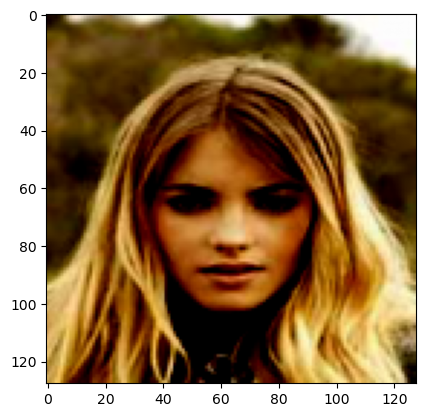

In [193]:
plt.imshow(train_dataset[18][0].permute(1, 2, 0))

In [188]:
transformlowres = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ,transforms.Resize((32, 32))
])

In [190]:
test_dataset=datasets.CelebA(root="C:/Users/maddo/Downloads/COdes from Work/Working on now",split='train',target_type='attr',transform=transformlowres,download=True)

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.80674994..0.9978436].


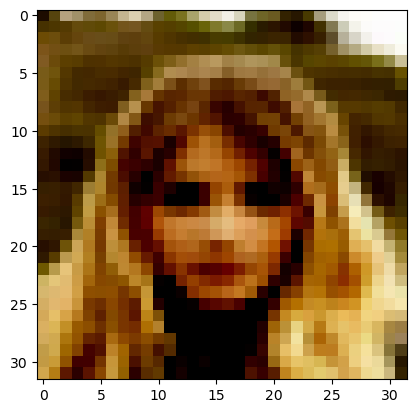

In [191]:
plt.imshow(test_dataset[18][0].permute(1, 2, 0))

In [204]:
class CustomImageDataset(Dataset):
    def __init__(self,traindata,testdata):
        self.test=testdata
        self.train=traindata

    def __len__(self):
        return len(self.test)

    def __getitem__(self, idx):
        return self.train[idx],self.test[idx]

In [205]:
newdata=CustomImageDataset(train_dataset,test_dataset)

In [206]:
train_loader=DataLoader(newdata, batch_size=32, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0000001..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99376816..0.99853987].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.984439..0.99969065].


torch.Size([32, 3, 128, 128]) torch.Size([32, 3, 32, 32])


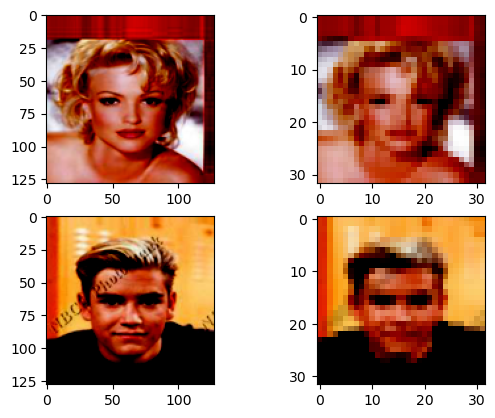

In [228]:
for x,y in train_loader:
    print(x[0].shape,y[0].shape)
    plt.subplot(2,2,1)
    plt.imshow((x[0][0]).permute(1,2,0))
    plt.subplot(2,2,2)
    plt.imshow(y[0][0].permute(1,2,0))
    plt.subplot(2,2,3)
    plt.imshow(x[0][6].permute(1,2,0))
    plt.subplot(2,2,4)
    plt.imshow(y[0][6].permute(1,2,0))    
    break